In [37]:
# General imports
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#Astropy imports
from astropy.cosmology import Planck18 as cosmo
import astropy.constants as const
import astropy.units as u
#Scipy Imports
from scipy.optimize import curve_fit
from scipy.integrate import quad
# Own code imports
from xi_calc import *
import sys
sys.path.insert(1, './Diffuse_IceCube_data/')

from diffuse_icecube_data import *

from matplotlib.offsetbox import AnchoredText


In [38]:
df = pd.read_csv('./Dataframes/Individual/dataframe.csv')

In [39]:
HerschelChu_201 = np.loadtxt("./Dataframes/System/Herschel_Chu.txt")
names_Chu = np.loadtxt('./Dataframes/System/Names.txt',dtype ='str')

DAsystem = np.array([i[1] for i in HerschelChu_201])
LIRsystem = np.array([i[3] for i in HerschelChu_201])
df_system = pd.DataFrame({ 'Optical name' : [i[1] for i in names_Chu],
                    'IRAS name' : [i[0] for i in names_Chu],
                     'log(LIR)': [i for i in LIRsystem],
                     'D_L [Mpc]': [i for i in DAsystem]})

# Estimating the IR generation rate of the GOALS sample

In [40]:
def complete_dataframe(DL_compl,source_type,syst):
    if source_type == 'LIRGs':
        if syst == 'individual':
             #only galaxies within completeness radius
            complete_df = df[(df['D_L [Mpc]'] < DL_compl) & (df['log(LIR)'] < 12) ]
        if syst == 'system':
             #only galaxies within completeness radius
            complete_df = df_system[(df_system['D_L [Mpc]'] < DL_compl) & (df_system['log(LIR)'] < 12) ]
    
    if source_type == '(U)LIRG': 
        if syst == 'individual':
            #only galaxies within completeness radius 
            complete_df = df[(df['D_L [Mpc]'] < DL_compl)] 
        else:
            #only galaxies within completeness radius
            complete_df = df_system[(df_system['D_L [Mpc]'] < DL_compl)] 
            
    return complete_df

complete_dataframe returns a dataframe with all the GOALS galaxies up to a completeness distance DL_complete where one has to specifiy if individual galaxies or systems are targeted and in addition whether LIRGs OR U/LIRGs are targeted.

In [41]:
def QIR(DL_compl,source_type,syst, AGNcorr):
    
    complete_df = complete_dataframe(DL_compl,source_type,syst)
    
    if AGNcorr == 'no':
        logLIR_complete_array = complete_df['log(LIR)'].to_numpy()
        LIR_complete_array = np.array([pow(10,i) for i in logLIR_complete_array])
        #total IR luminosity in solLum for complete set
        totalIR = (sum(LIR_complete_array*u.solLum)).to(u.erg/u.yr) 
        

    if AGNcorr == 'yes':
        logLIR_complete_array = complete_df['log(LIR)'].to_numpy()
        AGNfrac_complete_array = complete_df['AGNbol'].to_numpy()
        LIR_complete_array = np.array([(1-i)*pow(10,j) for i,j in zip(AGNfrac_complete_array,logLIR_complete_array)])
        totalIR = (sum(LIR_complete_array*u.solLum)).to(u.erg/u.yr) #total IR luminosity in solLum for complete set
         
    Dmax = DL_compl*u.Mpc 
    Volume = (4/3)*pow(Dmax,3)*np.pi #Completeness distance required to compute the volume in which IR is generated
    return [(totalIR/Volume).value,totalIR.value]

QIR return an IR generation rate, using comple_dataframe 

In [42]:
def Generation_rate_diff(DL_compl,source_type,E,Emin,Emax,alpha,eta,syst,agncorr):
    if alpha == 2:
        Rp = np.log(Emax/Emin)
    else:
        Rp = ((pow(Emin,-alpha+2)-pow(Emax,-alpha+2))/(alpha-2))*pow(E,alpha-2)
    return (QIR(DL_compl,source_type,syst,agncorr)[0]*eta)/Rp #erg Mpc-3 yr-1 

In [43]:
df_LIRG = complete_dataframe(1000,'LIRGs','individual')
Dmax_range_LIRG= df_LIRG.sort_values(by = 'D_L [Mpc]')['D_L [Mpc]'].to_numpy()+1

QIR_LIRG_individual = [QIR(i,'LIRGs','individual','no')[0] for i in Dmax_range_LIRG]
QIR_LIRG_individual_AGNcorr = [QIR(i,'LIRGs','individual','yes')[0] for i in Dmax_range_LIRG]


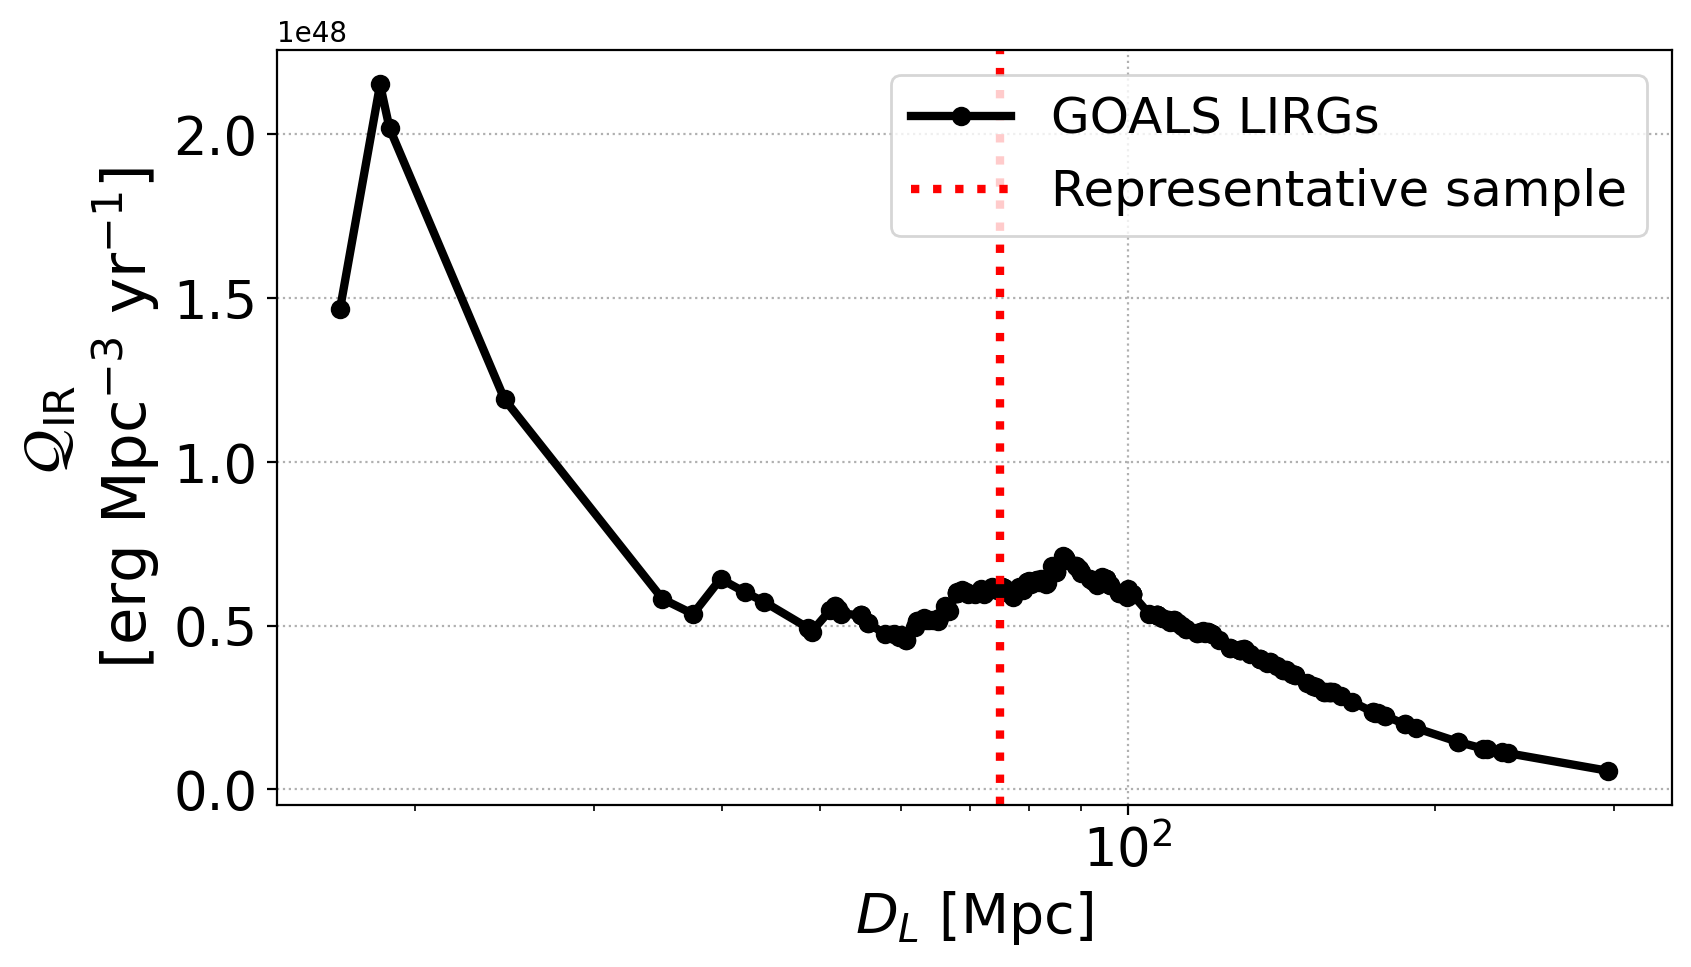

In [44]:
plt.figure(figsize=(9,5),dpi=200)

plt.plot(Dmax_range_LIRG,QIR_LIRG_individual, c = 'k', marker = 'o',ls = '-',label = 'GOALS LIRGs',linewidth =3)
plt.axvline(x= 75,c='r',ls='dotted',lw = 3,label= 'Representative sample')
plt.xticks(fontsize= 19)
plt.yticks(fontsize= 19)
plt.ylabel('$\\mathcal{Q}_{\\mathrm{IR}}$ \n [erg Mpc$^{-3}$ yr$^{-1}$]', fontsize = 22)
#plt.title('IR luminosity within the volume defined by $D_L$',fontsize = 20)
plt.xlabel('$D_L$ [Mpc]',fontsize = 20)
plt.legend(fontsize = 18)
plt.xscale('log')
plt.grid(ls='dotted')
#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/QIR.pdf",bbox_inches="tight")



In [45]:
len(df_LIRG[df_LIRG['D_L [Mpc]']<76])

62

# Redshift evolution parameter $\xi(z)$

In [31]:
z_range = np.arange(0,4,0.01)
xi_U_2 = [xi(2,i,'ULIRG') for i in z_range]
xi_SFR_2 = [xi(2,i,'starforming') for i in z_range]
xi_flat_2 = [xi(2,i,'flat') for i in z_range]

xi_U_3 = [xi(3,i,'ULIRG') for i in z_range]
xi_SFR_3 = [xi(3,i,'starforming') for i in z_range]
xi_flat_3 = [xi(3,i,'flat') for i in z_range]

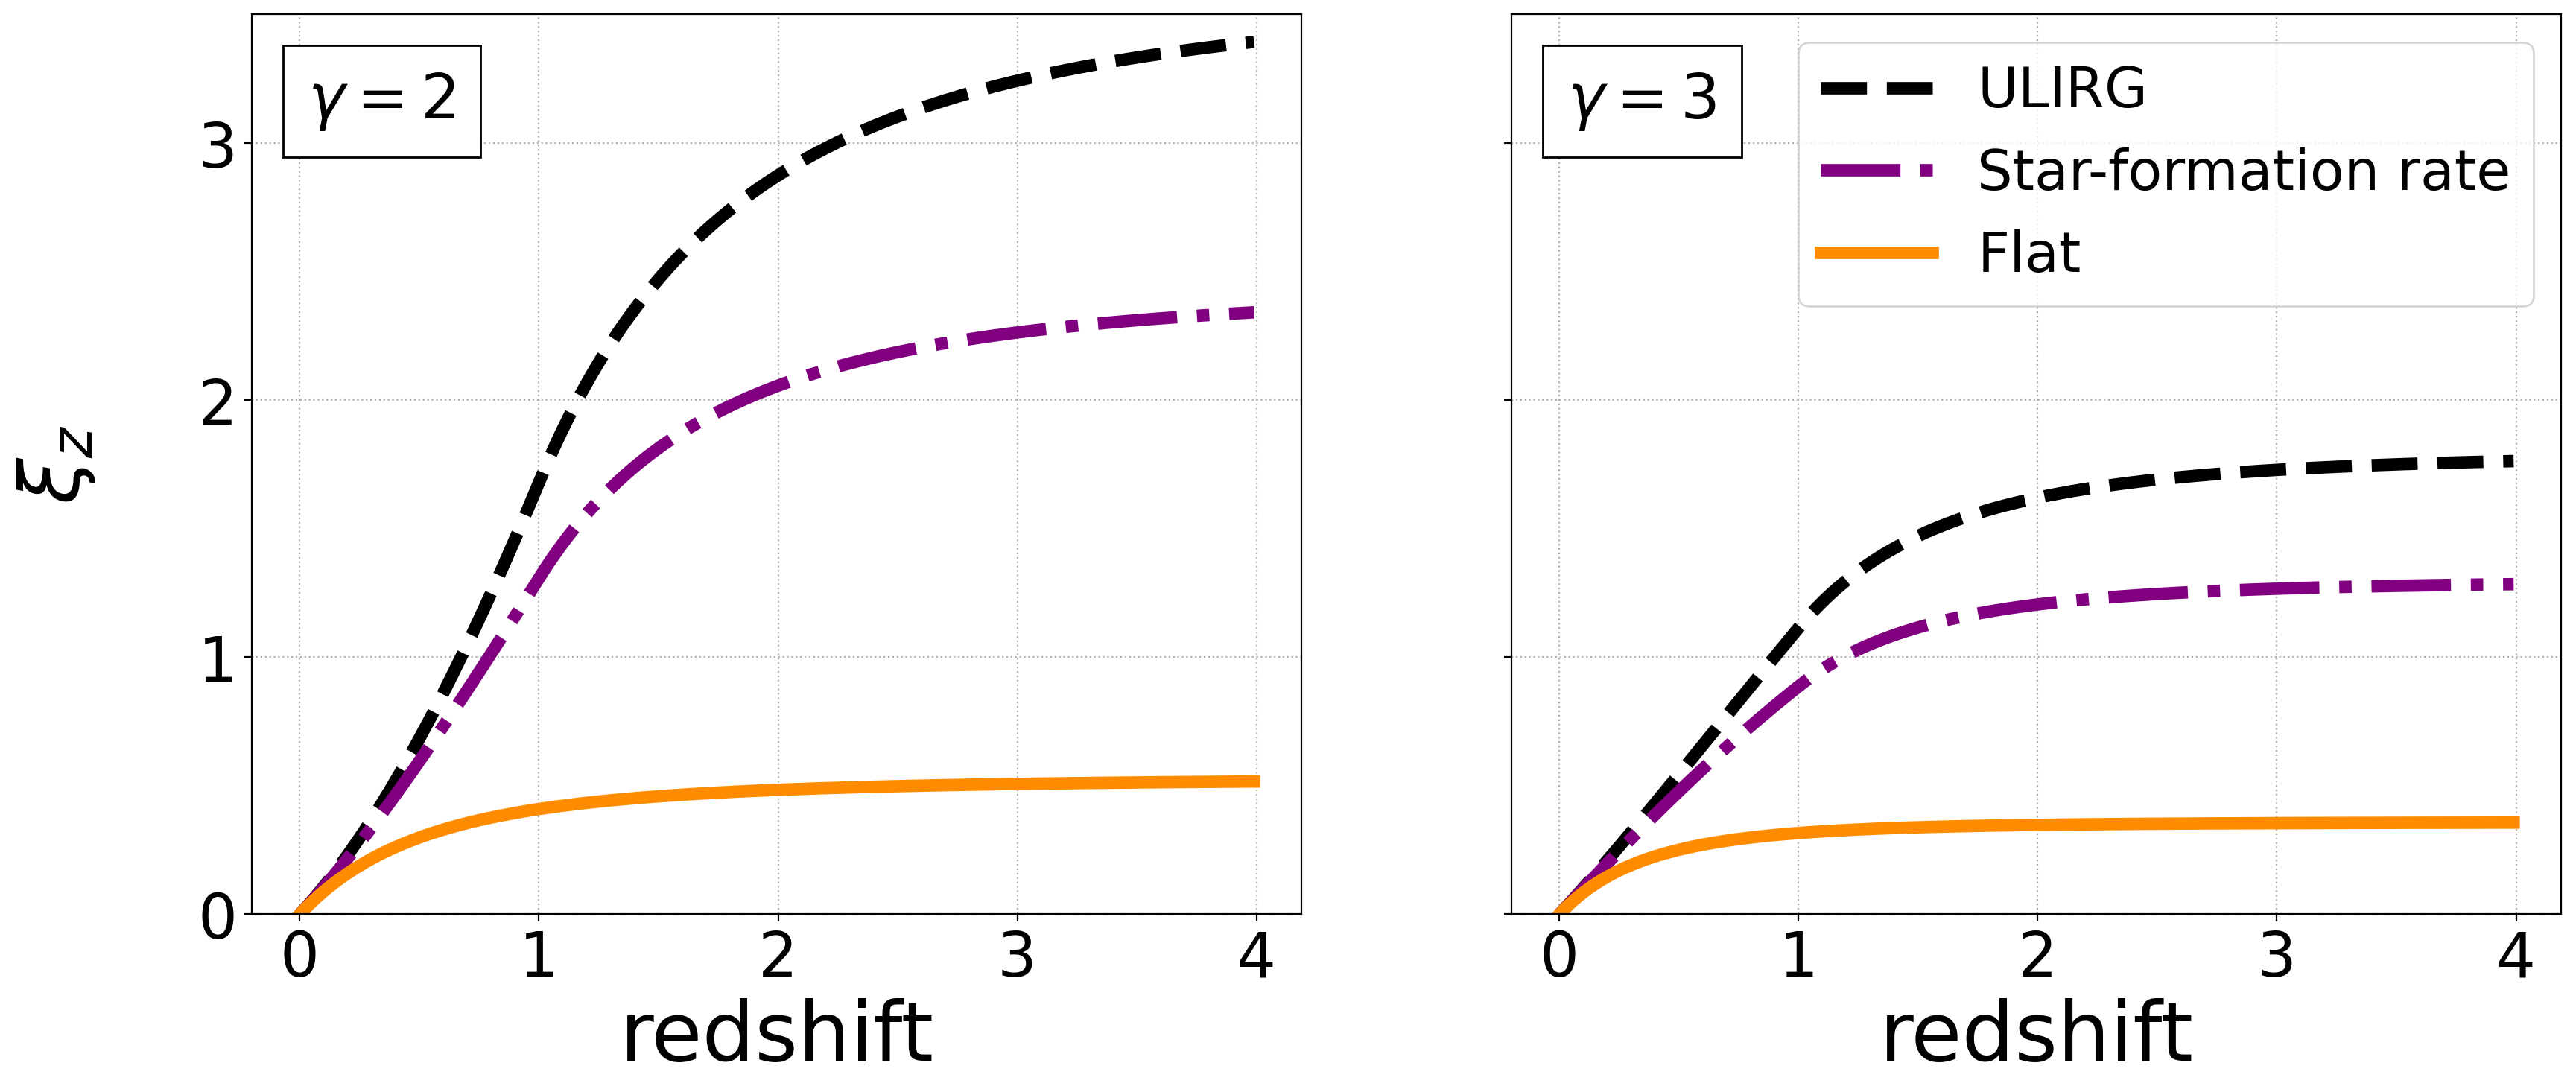

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,8),dpi = 200,sharey=True)
lw=6
ax[0].plot(z_range,xi_U_2, color='black', label = 'ULIRG', linestyle = '--', linewidth = lw)
ax[0].plot(z_range,xi_SFR_2, color='purple', label = 'Star-formation rate',linestyle ='-.', linewidth = lw)
ax[0].plot(z_range,xi_flat_2, color='darkorange', label = 'Flat',linewidth =  lw)
ax[0].set_yticks(np.linspace(0,4,5))
ax[1].plot(z_range,xi_U_3, color='black', label = 'ULIRG', linestyle = '--',linewidth = lw)
ax[1].plot(z_range,xi_SFR_3, color='purple', label =  'Star-formation rate', linestyle = '-.',linewidth = lw)
ax[1].plot(z_range,xi_flat_3, color='darkorange', label = 'Flat',linewidth = lw)
ax[1].set_ylim(0,3.5)

ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

ax[0].set_ylabel('$\\xi_z$\n', fontsize = 40)
ax[0].set_xlabel('redshift', fontsize = 40)
ax[1].set_xlabel('redshift', fontsize = 40)

#ax[0].legend(fontsize = 20)
ax[1].legend(fontsize = 27)


ax[0].grid(ls='dotted')
ax[1].grid(ls='dotted')

box_text_size = 30
anchored_text_l = AnchoredText('$\gamma=2$', loc= 'upper left',
                                     prop=dict(size=box_text_size))

box_text_size = 30
anchored_text_r = AnchoredText('$\gamma=3$', loc= 'upper left',
                                     prop=dict(size=box_text_size))
ax[0].add_artist(anchored_text_l)
ax[1].add_artist(anchored_text_r)


#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/Hz_evolution.png",bbox_inches="tight")


In [33]:
np.linspace(0,4,9)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [34]:
gamma_range = np.arange(2,3,0.01)
xi_U_z4 = [xi(i,4,'ULIRG') for i in gamma_range]
xi_SFR_z4 = [xi(i,4,'starforming') for i in gamma_range]
xi_flat_z4 = [xi(i,4,'flat') for i in gamma_range]
xi_U_z1 = [xi(i,1,'ULIRG') for i in gamma_range]
xi_SFR_z1 = [xi(i,1,'starforming') for i in gamma_range]
xi_flat_z1 = [xi(i,1,'flat') for i in gamma_range]

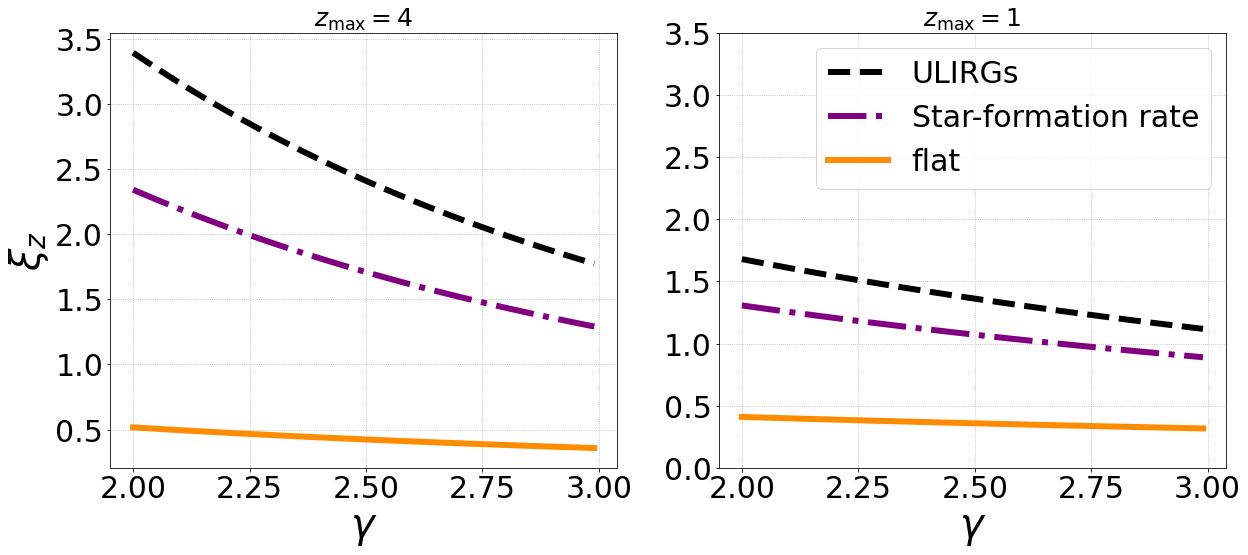

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
lw=6

ax[0].plot(gamma_range,xi_U_z4, color='k', label = 'ULIRGs', linestyle = '--', linewidth = lw)
ax[0].plot(gamma_range,xi_SFR_z4, color='purple', label = 'Star-formation rate',linestyle ='-.', linewidth = lw)
ax[0].plot(gamma_range,xi_flat_z4, color='darkorange', label = 'flat',linewidth = lw )
ax[1].plot(gamma_range,xi_U_z1, color='k', label = 'ULIRGs', linestyle = '--',linewidth = lw)
ax[1].plot(gamma_range,xi_SFR_z1, color='purple', label = 'Star-formation rate', linestyle = '-.',linewidth = lw)
ax[1].plot(gamma_range,xi_flat_z1, color='darkorange', label = 'flat',linewidth =lw)
ax[1].set_ylim(0,3.5)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)
ax[1].tick_params(axis='both', which='major', labelsize=30)

ax[0].set_ylabel('$\\xi_z$', fontsize = 40)
ax[0].set_xlabel('$\gamma$', fontsize = 40)
ax[1].set_xlabel('$\gamma$', fontsize = 40)

#ax[0].legend(fontsize = 20)
ax[1].legend(fontsize = 30)

ax[0].set_title('$z_{\mathrm{max}} = 4$', fontsize = 25)
ax[1].set_title('$z_{\mathrm{max}} = 1$', fontsize = 25)


ax[0].grid(ls = 'dotted')
ax[1].grid(ls = 'dotted')

#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/xivsgamma.png",bbox_inches="tight")


\begin{equation}
    E^{2}_{\nu_{}}\Phi_{\nu_i} \approx \frac{1}{3}\frac{c}{4\pi} t_{H} \xi_{z}\frac{3K}{4(1+K)} \min[1,f_{\mathrm{pp}/p\gamma}] \left(E_{\mathrm{CR}}\mathcal{Q}_{E_\mathrm{CR}}\right)~.
\end{equation}

Here I should also include the value of $\xi$ as function of the spectral index. 

# Relating the integrated CR generation rate to the differential rate via $R$ 

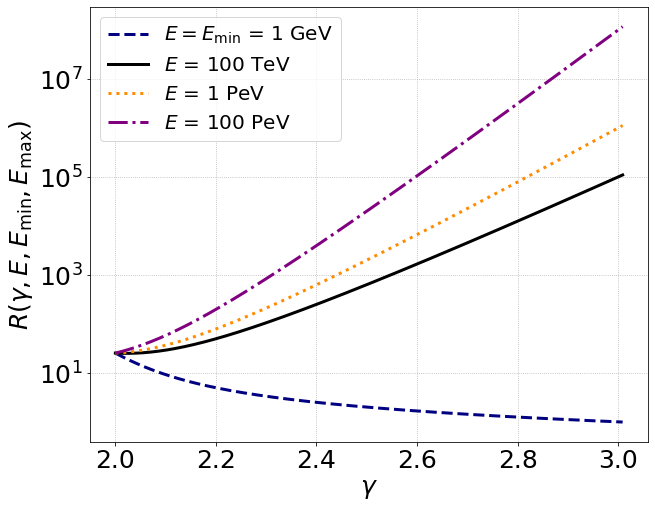

In [15]:
def Rp(E,Emin,Emax,s):
    if s==2:
        return np.log(Emax/Emin)
    else: 
        return ((pow(Emin,-s+2)-pow(Emax,-s+2))/(s-2))*pow(E,s-2)
    
fig3 = plt.figure(figsize=(10,8))
s_range = np.arange(2,3.01,0.001)
Rp = np.vectorize(Rp)

#plt.axhline(y=200,c ='k',ls='--')
#plt.axvline(x=2.2,c ='k',ls='--')

plt.plot(s_range, Rp(1,1,1e11,s_range),'--', label = '$E=E_{\min}$ = 1 GeV',linewidth = 3,c='navy')
plt.plot(s_range, Rp(1e5,1,1e11,s_range), label= '$E$ = 100 TeV',linewidth = 3,c='black')
plt.plot(s_range, Rp(1e6,1,1e11,s_range),linestyle = 'dotted', label= '$E$ = 1 PeV',linewidth = 3,c='darkorange')
plt.plot(s_range, Rp(1e8,1,1e11,s_range),linestyle = 'dashdot', label= '$E$ = 100 PeV',linewidth = 3,c='purple')
plt.legend(fontsize = 20)
plt.yscale('log')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('$\\gamma$',fontsize = 25)
plt.ylabel('$R(\\gamma, E, E_{\\min}, E_{\\max})$',fontsize = 25)
plt.grid(ls='dotted')
#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/R.png",bbox_inches="tight")

PhD thesis of M. Vereecken: R=200 for $\alpha = 2.2$ and $E = 100$ PeV. This is confirmed by the above plot.

In [16]:
Rp(E=1,Emin=60e3,Emax=1e8,s=2)

array(7.4185809)

# Estimating the diffuse neutrino flux

\begin{equation}
    E^{2}_{\nu_{}}\Phi_{\nu_i} \approx \frac{1}{3}\frac{c}{4\pi} t_{H} \xi_{z}\frac{3K}{4(1+K)} \min[1,f_{\mathrm{pp}/p\gamma}] \left(E_{\mathrm{CR}}\mathcal{Q}_{E_\mathrm{CR}}\right)~.
\end{equation}

In [17]:
def nuflux(E,Emin,Emax, alpha,DL_compl,xiz,eta,fpp,source_type,channel,syst,agncorr):
    #inverse of Hubble parameter in seconds
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) 
    ctH = (const.c).to(u.cm/u.s)*tH # unit: cm
    
    Generation_rate_nunits = (Generation_rate_diff(DL_compl,source_type,E,Emin,Emax,alpha,eta,syst,agncorr)*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.GeV/(pow(u.cm,3)*u.s)) #unit: GeV/(cm3 s)
    Kpi = lambda channel: 0.5 if(channel == 'pp') else 3/8
    
    # unit: GeV/(cm2 s sr)
    return ((1/3)*((ctH*xiz)/(4*np.pi))*Kpi(channel)*fpp*Generation_rate_nunits).value


In [18]:
Emin = 1e3
Emax = 60*1e6
eta_tot = ((1e51*0.1*5.97e-46*(u.erg/u.yr)).to(u.erg/u.s)).value #BH cutoff mass standard SB99 
print(eta_tot)
diffuse_lirg_flux = [nuflux(E=0, #gamma=2 does not matter
                            Emin=Emin, 
                            Emax=Emax, 
                            alpha=2,
                            DL_compl=i,
                            xiz= xi(2,4,'ULIRG'),
                            eta= eta_tot,
                            fpp=1,
                            source_type='LIRGs',
                            channel='pp',
                            syst='individual',
                            agncorr='no') for i in Dmax_range_LIRG ]


0.0018917788424975283


In [19]:
 xi(2,4,'ULIRG')

3.3940574443018976

(4.0393032212195415e-09, 1.633640451621471e-07)

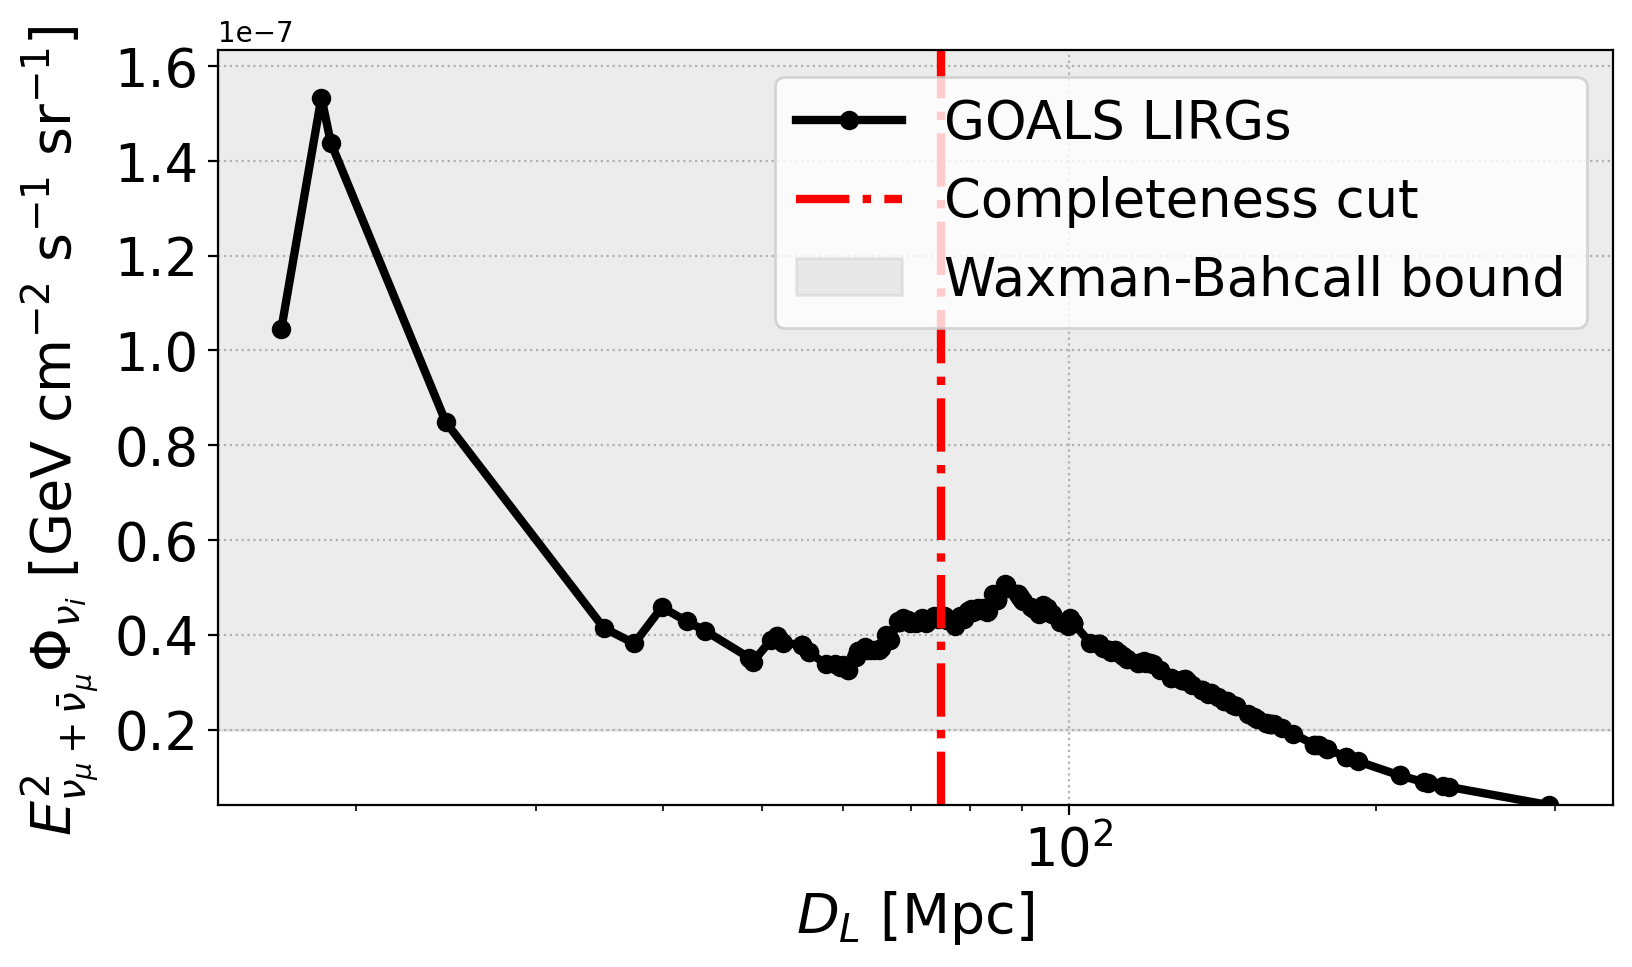

In [56]:
fig3=plt.figure(figsize=(9,5),dpi=200)

plt.plot(Dmax_range_LIRG,diffuse_lirg_flux,linewidth = 3, label = 'GOALS LIRGs',c='k',marker='o')
plt.axhspan(2 * 1e-8 , 1e-5, 
            alpha=0.15, color='grey', label='Waxman-Bahcall bound')
plt.axvline(x = 75, linestyle = 'dashdot',c = 'r', label = 'Completeness cut', linewidth = 3)
#plt.yscale('log')
plt.xlabel('$D_L$ [Mpc]',fontsize = 20)
plt.ylabel('$E^{2}_{\\nu_{\\mu}+\\bar{\\nu}_\mu}\Phi_{\\nu_i}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$] ',fontsize = 20)
plt.yticks(fontsize = 19)
plt.xticks(fontsize = 19)
plt.legend(fontsize = 19)
plt.grid(ls='dotted')
plt.xscale('log')
plt.ylim(min(diffuse_lirg_flux),max(diffuse_lirg_flux)+1e-8)


In the paper we present the diffuse neutrino flux from the LIRG population for specific values, computed with the code below

In [22]:
def Normalizing_factor(xiz, R,fpp,eta_tot,Qir):
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) #inverse of Hubble parameter in seconds
    ctH = (const.c).to(u.cm/u.s)*tH # unit: cm
    qq= fpp*(Qir*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.GeV/(pow(u.cm,3)*u.s))
    print((Qir*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.erg/(pow(u.Mpc,3)*u.yr)))
    print(eta_tot*qq)
    return xiz*R*(1/6)*(ctH/(4*np.pi*u.sr))*eta_tot*qq

In [23]:
print(Normalizing_factor(3.4,1/25,1,eta_tot, QIR(75,'LIRGs','individual','no')[0]))

6.2213173960085935e+47 erg / (Mpc3 yr)
7.922946549880088e-34 GeV / (cm3 s)
1.953906486921294e-08 GeV / (cm2 s sr)


In [24]:
print(Normalizing_factor(3.4,1/np.log((60*1000)/1),1,eta_tot, QIR(75,'LIRGs','individual','no')[0]))

6.2213173960085935e+47 erg / (Mpc3 yr)
7.922946549880088e-34 GeV / (cm3 s)
4.439849017738573e-08 GeV / (cm2 s sr)


As such we find that for a completeness distance of $D_L \approx 75$ Mpc the IR generation rate is $\mathcal{Q}_{\rm IR} \approx 10^{47.79}$ erg Mpc$^{-3}$ s$^{-1}$. 

# Comparing to the IceCube diffuse measurements

First we perform a fit to the IceCube data using the expression: 

\begin{equation}
    E^{2}_{\nu_{}}\Phi_{\nu_i} \approx \frac{1}{3}\frac{c}{4\pi} t_{H} \xi_{z}\frac{3K}{4(1+K)} \min[1,f_{\mathrm{pp}/p\gamma}] \left(E_{\mathrm{CR}}\mathcal{Q}_{E_\mathrm{CR}}\right)~.
\end{equation}

In this fit the parameter $\eta_{tot}$ and the spectral index $\gamma$ are the fit parameters. For this we use $\xi(\gamma = 2.37,z=4)$ as fixed parameter in the equation. As the fit of $\gamma$ is independent of the value of $\xi$ we decided to take $\xi(\gamma = 2.37,z=4)$ for consistency. Moreover, for $E_{min}$ and $E_{max}$ we used the 20 times the lowerst and highest value for the energy range of the observed muon neutrinos. 

In [25]:
def nuflux_fit(E,eta,alpha,xi,fpp):
    def Generation_rate_diff_fit(E,alpha,eta):
        # computed following E_nu = E_cr / 20
        Emin = energy_range_numu[0]*20
        Emax = energy_range_numu[-1]*20
        if alpha == 2:
            Rp = np.log(Emax/Emin)
        else:
            Rp = ((pow(Emin,-alpha+2)-pow(Emax,-alpha+2))/(alpha-2))*pow(E,alpha-2)
        return (6.2213173960085935e+47*eta)/Rp #erg Mpc-3 yr-1, this is the value found for D_L,compl = 75 Mpc 
    
    complete_df = df[(df['D_L [Mpc]'] < 75) & (df['log(LIR)'] < 12) ]
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) #inverse of Hubble parameter in seconds
    
    ctH = ((const.c).to(u.cm/u.s)*tH).value # unit: cm
    
    Generation_rate_nunits = (Generation_rate_diff_fit(E,eta,alpha)*(u.erg/(pow(u.Mpc,3)*u.yr))).to(u.GeV/(pow(u.cm,3)*u.s)) #unit: GeV/(cm3 s)
    
    Kpi = 0.5
    return (1/3)*((ctH*xi)/(4*np.pi))*Kpi*fpp*(Generation_rate_nunits).value# unit: GeV/(cm2 s sr)


In [26]:
fpp_vals= np.arange(0.1,1,0.01)
eta_fit = []
gamma_fit = []


for i in fpp_vals:
    popt, pcov = curve_fit(lambda E, eta,alpha: nuflux_fit(E, eta, alpha,i,3.4), 
                            energy_range_numu,flux_numu*energy_range_numu**2)
    
   
    eta_fit += [popt[1]]  
    gamma_fit += [pcov[0]]  



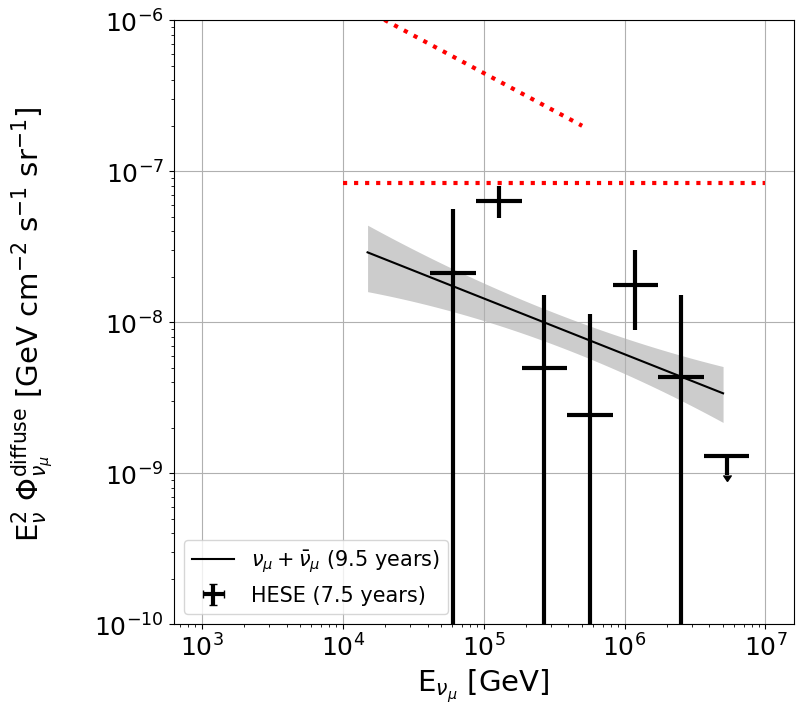

In [27]:
# Plot the HESE data up to index i
i = len(energy)
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
Energy_plot = np.logspace(np.log10(1e4),np.log10(1e7),12)
Energy_plots =  np.logspace(np.log10(1e3),np.log10(5e5),12)
diffuse_LIRG_flux = [nuflux(i,energy_range_numu[0]*20, energy_range_numu[-1]*20, 2,75,3.4,1,eta_tot,'LIRGs','pp','individual','no') for i in Energy_plot]
diffuse_LIRG_flux2 = [nuflux(i,energy_range_numu[0]*20, energy_range_numu[-1]*20, 2.5,75,3.4,1,eta_tot,'LIRGs','pp','individual','no') for i in Energy_plots]

HESE = plt.errorbar(energy[:i],
                   flux[:i],
                   xerr=[energy_lower_err[:i],energy_upper_err[:i]],
                   yerr=[flux_lower_err[:i],flux_upper_err[:i]],
                   uplims=upper_limits[:i],
                   marker="o",
                   markersize=0,
                   color="k",
                   linestyle="none",
                   linewidth=3,
                   capsize=0, label = 'HESE (7.5 years)')


en = np.arange(1e4,5e6,100)

# Plot the diffuse nu_mu best fit
plt.xscale('log')
plt.yscale('log')
numu_best = plt.plot(energy_range_numu,
                    flux_numu*energy_range_numu**2,
                    color="k",
                    linestyle='-', label= '$\\nu_\\mu + \\bar{\\nu}_{\\mu}$ (9.5 years)') # dashdotdotted


plt.plot(Energy_plot, diffuse_LIRG_flux, linewidth = 3,c='r', ls='dotted')
plt.plot(Energy_plots, diffuse_LIRG_flux2, linewidth = 3,c='r', ls='dotted')


# Plot the error band of the diffuse nu_mu best fit



numu_err = plt.fill_between(energy_numu,
                           flux_lower,
                           flux_upper,
                           color="grey",
                           lw=0,
                           alpha=0.4)


plt.ylim(1e-10,1e-6)
#plt.xlim(1e4,4e7)
plt.xlabel ("E$_{\\nu_\\mu}$ [GeV]", fontsize = 21)
plt.ylabel('E$_{\\nu}^2$ $\\Phi ^{\\mathrm{diffuse}}_{\\nu_\\mu}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$] \n', fontsize = 21)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 15)
plt.grid()
#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/fit.png",bbox_inches="tight")


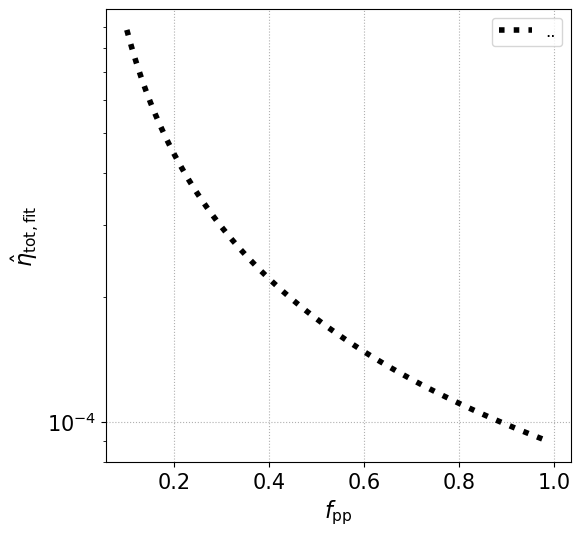

In [28]:
fig=plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(fpp_vals, eta_fit,linestyle = 'dotted', c = 'k',label ="..",lw = 4)
plt.xlabel('$f_{\mathrm{pp}}$',fontsize = 16)
plt.ylabel('$\\hat{\\eta}_{\mathrm{tot, fit}}$', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
plt.yscale('log')
plt.grid(ls = 'dotted')
#plt.savefig("/Users/yarno/Documents/PhD/Pictures/Extrapolation_plots/etatotvsfpp.png",bbox_inches="tight")


This plot shows the fitted $\hat{\eta}_{tot}$ for a range of fixed $f_{pp}$ values. The black solid line shows the fit for a redshift parameter consistent with a ULIRG evolution up to redshift 1 and the red dashed line up to $z=4$. In the fit, the spectral index is also a free parameter and is found to be $\hat{\gamma} = 2.37$. I made this plot to investigate the range of the $\eta_{tot}$ parameter and more specifically the effect of the extrapolation only being justified up to a certain redshift.

As follow-up I should also check the effect of changing Emin and Emax.

# Can we extrapolate all the way to $z=4$ ?

It was brought to my attention that $L_{\mathrm{IR}} > 10^{11}~L_{\odot}$ locally targets merger-driven starbursts but at high redshift such galaxies seem to evolve individually rather than in a merger. If the merger aspect is crucial for efficient neutrino production, then the extrapolation might only be relevant up to a certain redshift. Here we we investigate how the neutrino flux prediction is affected as function of redshift, which affects $\xi(z)$. 

In [29]:

F_xi_U = [nuflux(0,Emin, Emax, 2,75,xi(2,i,'ULIRG'),eta_tot,1,'(U)LIRG','pp','individual','no')for i in z_range]

F_xi_SFR = [nuflux(0,Emin, Emax, 2,75,xi(2,i,'starforming'),eta_tot,1,'(U)LIRG','pp','individual','no') for i in z_range]


(array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

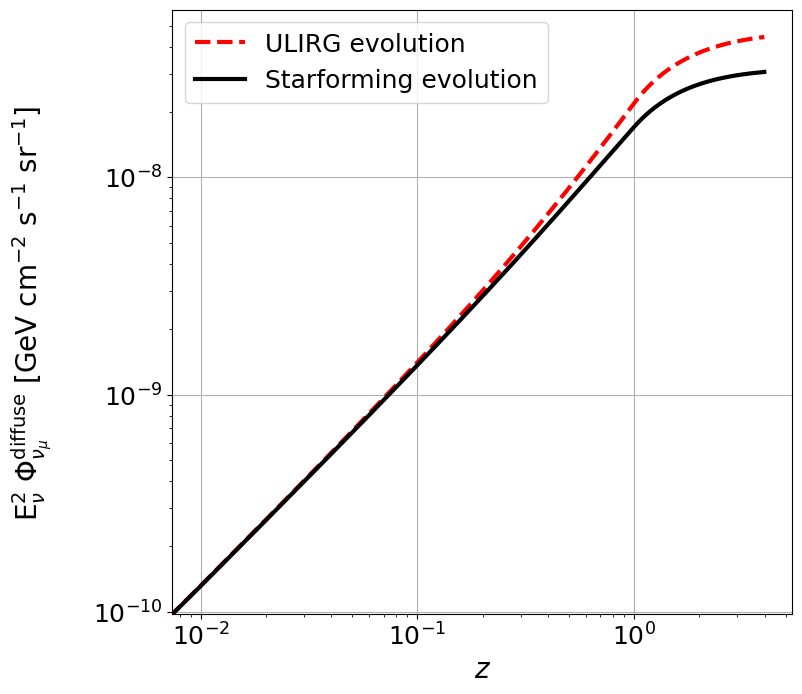

In [30]:
fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(z_range, F_xi_U, label = 'ULIRG evolution', linestyle = '--', c = 'red',linewidth = 3)
plt.plot(z_range, F_xi_SFR, label = 'Starforming evolution', c = 'k', linewidth = 3)
#plt.axhline(y= 2e-8, linestyle = '--', color = 'orange',linewidth = 3, label = 'Waxman-Bahcall prediction')
plt.ylabel('E$_{\\nu}^2$ $\\Phi ^{\\mathrm{diffuse}}_{\\nu_\\mu}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$] \n', fontsize = 20)
plt.xlabel('$z$', fontsize = 20)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend(fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

This plot shows the dependence of the diffuse neutrino flux prediction as function of the extrapolation redshift. I made this plot after getting the comment that high-redshift LIRGs are different from local LIRGs and therefore one should be carefull with an extrapolation over cosmic history. 

# Cross check

To cross check the above results we check wether we find the same results if we use a scaling of the uncorrected supernova rate obtained from the dataframe vs applying a conversion factor to the IR luminosity density. This seems like a trivial idea but it checks if a mistake was made in the code.  

In [31]:
def nuflux_check(DLcompl,df,E, Emin, Emax, s, zmax):
    tH = (pow(cosmo.H(0),-1)).to((u.Mpc*u.s)/u.Mpc) #inverse of Hubble parameter in seconds
    ctH = (const.c).to(u.cm/u.s)*tH # unit: cm
    df_test = df[(df['D_L [Mpc]'] < DLcompl) & (df['log(LIR)'] < 12) ]
    ESN = 1e51
    etaSN = 0.1
    V = (4/3)*np.pi*pow(DLcompl,3)
    LCR_test = np.sum(df_test['un-corr Supernova rate [yr$^{-1}$] '])*ESN*etaSN
    QCR_test = ((LCR_test/V)*(u.erg*pow(u.yr,-1)*pow(u.Mpc,-3))).to(u.GeV*pow(u.s,-1)*pow(u.cm,-3))
    return xi(s,zmax,'ULIRG')*pow(Rp(E, Emin, Emax, s),-1)*(1/6)*(ctH/(4*np.pi*u.sr))*QCR_test

    

In [32]:
kwargs_Rp = {'E':200,"Emin":1, "Emax":1e11,"s":2, "zmax":4}
nuflux_check(75,df, **kwargs_Rp)

<Quantity 1.92647013e-08 GeV / (cm2 s sr)>

In [33]:
result = (((pow(10,11.11)*u.solLum).to(u.erg*u.s**-1)).value*5.97e-46*0.1
          *1e51*u.erg)/((pow(10,11.11)*u.solLum).to(u.erg*u.yr**-1).value)
result

<Quantity 0.00189178 erg>

(!) The conclusion: the parameter $\eta_{\rm tot}$, defined as $\mathcal{L}_{\rm CR}/\mathcal{L}_{\rm IR}$ is of the order of 0.1% for [$\mathcal{L}_{\rm IR}$] = [$\mathcal{L}_{\rm CR}$]  = erg/yr